### Ablation tests by means of different distributions

The goal of this notebook is to quantitatively verify that the attributions with different background distributions match our intuition

In [1]:
import xgboost, shap, os, scipy, sklearn, sys, pickle
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import numpy as np

from deepshap.data import preprocessed_data, load_nhanes, get_nhanes_feat_names
from model import nhanes_mlp

# Load data
trainx, trainy, _, _, testx, testy = load_nhanes()
feat_names = get_nhanes_feat_names()

# Load model
model = nhanes_mlp()

# Get the raw un-standardized data
X, y = preprocessed_data()
pids = np.unique(X.index.values)
train_pids,test_pids = train_test_split(pids, random_state=0)
strain_pids,valid_pids = train_test_split(train_pids, random_state=0)
strain_inds = np.where([p in strain_pids for p in X.index.values])[0]
raw_trainx = X.iloc[strain_inds,:]

In [2]:
# Get clusters (first two features are sex and age)
n_clusters = 8
kmeans_path = "models/kmeans_gender_age.p"
if not os.path.exists(kmeans_path):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(trainx[:,0:2])
    pickle.dump(kmeans,open(kmeans_path, "wb"))
else:
    kmeans = pickle.load(open(kmeans_path, "rb"))
cluster_inds = kmeans.predict(trainx[:,0:2])
clusters     = [trainx[cluster_inds==i] for i in range(n_clusters)]
raw_clusters = [raw_trainx[cluster_inds==i] for i in range(n_clusters)]

Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.


In [4]:
#### Load clustered backgrounds ####    
ATTR_PATH = "attr/deepshap_kmeans{}_clusbg_attr_lst.p".format(n_clusters)
clus_attr_lst = pickle.load(open(ATTR_PATH, "rb"))

#### Load random backgrounds ####    
ATTR_PATH = "attr/deepshap_kmeans{}_randbg_attr_lst.p".format(n_clusters)
rand_attr_lst = pickle.load(open(ATTR_PATH, "rb"))

In [5]:
i = 2 # Cluster index

# Collect attributions and samples
clus_attr = clus_attr_lst[i]
rand_attr = rand_attr_lst[i]
rtrainx2  = raw_clusters[i]
trainx2   = clusters[i]

# Determine gender/age range of cluster
gender = "Male"
if rtrainx2["sex_isFemale"].mean() == 1: gender = "Female"
age_min = rtrainx2["age"].min()
age_max = rtrainx2["age"].max()

# Print and plot results
print("#"*20)
print("### Cluster: {}, Gender: {}, Age: [{}, {}] ###".format(i, gender, age_min, age_max))
print("#"*20)

####################
### Cluster: 2, Gender: Male, Age: [62, 75] ###
####################


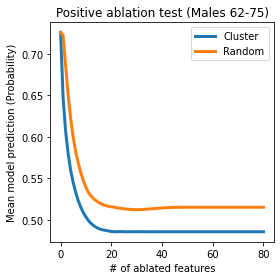

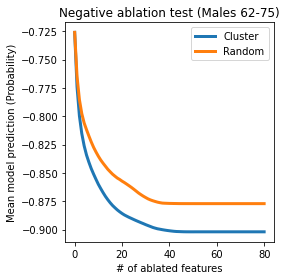

In [9]:
from ablate import ablate

mean_ref = np.repeat(trainx2.mean(0)[np.newaxis,:], trainx2.shape[0], axis=0)
clus_ablated_preds = ablate(model.predict, clus_attr, trainx2, impute="pos", refer=mean_ref)
rand_ablated_preds = ablate(model.predict, rand_attr, trainx2, impute="pos", refer=mean_ref)

# Plot ablated predictions
plt.rcParams["figure.figsize"] = (4,4)
plt.plot(clus_ablated_preds, label="Cluster", linewidth=3.0)
plt.plot(rand_ablated_preds, label="Random", linewidth=3.0)
plt.legend()
plt.title("Positive ablation test (Males 62-75)")
plt.ylabel("Mean model prediction (Probability)")
plt.xlabel("# of ablated features")
plt.tight_layout()
plt.savefig("fig/pos_ablation_old_males.pdf")
plt.show()

mean_ref = np.repeat(trainx2.mean(0)[np.newaxis,:], trainx2.shape[0], axis=0)
clus_ablated_preds = ablate(model.predict, clus_attr, trainx2, impute="neg", refer=mean_ref)
rand_ablated_preds = ablate(model.predict, rand_attr, trainx2, impute="neg", refer=mean_ref)

# Plot ablated predictions
plt.rcParams["figure.figsize"] = (4,4)
plt.plot(-np.array(clus_ablated_preds), label="Cluster", linewidth=3.0)
plt.plot(-np.array(rand_ablated_preds), label="Random", linewidth=3.0)
plt.legend()
plt.title("Negative ablation test (Males 62-75)")
plt.ylabel("Mean model prediction (Probability)")
plt.xlabel("# of ablated features")
plt.tight_layout()
plt.savefig("fig/neg_ablation_old_males.pdf")
plt.show()